# TRUSTED ZONE (TEXT)
This notebook contains the scripts needed for the extraction of text from the formatted zone, its processing and cleaning of the data and storage to the trusted Zone. The trusted zone is represented by another bucket and aims to replicate the same folder structure as the formatted zone. The difference is that the data has been processed and transform in order to clean and ensure a clean texts.

This notebook focuses only on text (the equivalent notebooks for the other types of data can be found in the same folder). Particularly, the following scripts are responsible of the following tasks:

Extraction of text from formatted zone. Treatment and processing of the data, to ensure data quality.

First, we will connect to MinIO and prepare the new bucket:

In [11]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

new_bucket = "trusted-zone"
try:
    minio_client.create_bucket(Bucket=new_bucket)
except (minio_client.exceptions.BucketAlreadyExists, minio_client.exceptions.BucketAlreadyOwnedByYou):
    print(f"Bucket '{new_bucket}' already exists")

Bucket 'trusted-zone' already exists


This function is used to identify potential irregularities or formatting issues in the text.
It highlights specific problems detected in the content.
By executing it both before and after the text-cleaning process, we can evaluate the impact of our treatment.

In [24]:
def analisi_text(text):
    problemas = {}

    control_chars = [c for c in text if unicodedata.category(c)[0] == 'C' and c not in '\n\t']
    problemas["caracteres_control"] = len(control_chars)

    lineas_con_espacios = [line for line in text.splitlines() if line.startswith(" ") or line.endswith(" ")]
    problemas["lineas_con_espacios"] = len(lineas_con_espacios)

    saltos_multiples = bool(re.search(r"\n\s*\n\s*\n+", text))
    problemas["saltos_multiples"] = saltos_multiples

    lineas_vacias = [line for line in text.splitlines() if not line.strip()]
    problemas["lineas_vacias"] = len(lineas_vacias)

    caracteres_invalidos = re.findall(r"[^\w\s\.\,\;\:\!\?\(\)\[\]\"\'\-\+\=\%\&\$\/\@\#\*]", text)
    problemas["caracteres_especiales"] = len(caracteres_invalidos)

    comillas_tipograficas = re.findall(r"[“”«»]", text)
    apostrofes_tipograficos = re.findall(r"[‘’]", text)
    problemas["comillas_tipograficas"] = len(comillas_tipograficas)
    problemas["apostrofes_tipograficos"] = len(apostrofes_tipograficos)

    guiones_multiples = bool(re.search(r"-{2,}", text))
    problemas["guiones_multiples"] = guiones_multiples

    texto_vacio = not text.strip()
    problemas["texto_vacio"] = texto_vacio

    return{
        "problems_control_caracters": problemas["caracteres_control"],
        "problems_lineas_con_espacios": problemas["lineas_con_espacios"],
        "problems_saltos_multiples": problemas["saltos_multiples"],
        "problems_lineas_vacias": problemas["lineas_vacias"],
        "problems_caracteres_especiales": problemas["caracteres_especiales"],
        "problems_comillas_tipograficas": problemas["comillas_tipograficas"],
        "problems_apostrofes_tipograficos": problemas["apostrofes_tipograficos"],
        "problems_guiones_multiples": problemas["guiones_multiples"],
        "problems_texto_vacio": problemas["texto_vacio"]
    }

In this step, we apply the previously defined function to gather statistics for each text, helping us detect possible issues or anomalies.
Once all texts have been analyzed, we use the head() function to preview the first five entries and evaluate whether the cleaning process will be sufficient.

In [26]:
import pandas as pd
analysis = []

paginator = minio_client.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket="formatted-zone", Prefix="text/"):
    for obj in tqdm(page.get("Contents", []), desc="Processant fitxers de text"):
        key = obj["Key"]
        filename = key.split("/")[-1]
        response = minio_client.get_object(Bucket="formatted-zone", Key=key)
        text = response["Body"].read().decode("utf-8", errors="ignore")
        analysis.append(analisi_text(text))
        

df = pd.DataFrame(analysis)
df.head()

Processant fitxers de text: 100%|██████████| 5/5 [00:00<00:00, 106.46it/s]


,problems_control_caracters,problems_lineas_con_espacios,problems_saltos_multiples,problems_lineas_vacias,problems_caracteres_especiales,problems_comillas_tipograficas,problems_apostrofes_tipograficos,problems_guiones_multiples,problems_texto_vacio
0,0,0,False,53,15,0,0,False,False
1,0,0,False,42,7,0,0,False,False
2,0,1,False,132,16,0,0,False,False
3,0,0,False,53,3,0,0,False,False
4,0,0,True,21,0,0,0,False,False


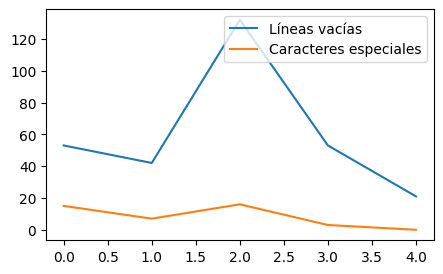

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.plot(df['problems_lineas_vacias'], label='Líneas vacías')
plt.plot(df['problems_caracteres_especiales'], label='Caracteres especiales')
plt.legend()
plt.show()

This script is responsible for extracting text files from the Formatted Zone, processing and cleaning them to ensure their quality, and finally storing them in the Trusted Zone. The process begins by reading all text files from the formatted-zone bucket and then applying various treatments to improve their quality and readability.

First, it normalizes Unicode characters using the NFKD format to unify special characters and ensure consistency in encoding. Then, it removes all control and non-printable characters, keeping only the necessary line breaks and tabs that preserve the text’s structure.

Next, it cleans up multiple whitespaces by converting all consecutive spaces and tabs into a single space, and normalizes multiple line breaks by limiting them to a maximum of two empty lines to enhance readability. It also trims leading and trailing spaces from each line and removes completely empty lines.

The process also includes cleaning problematic special characters, keeping only alphanumeric characters, spaces, basic punctuation, and necessary symbols. It normalizes typographic quotation marks by converting them to straight quotes, and typographic apostrophes to standard apostrophes, ensuring consistency.

Finally, it cleans up multiple hyphens by converting them into a single hyphen, normalizes spacing around punctuation by removing spaces before punctuation marks and ensuring one space after them, and applies a final trim of leading and trailing spaces from the entire text. The result is a set of cleaned and optimized text files stored in the Trusted Zone, preserving the original folder structure.

In [22]:
import io
import re
import unicodedata
from tqdm import tqdm

bucket_origen = "formatted-zone"
bucket_desti = "trusted-zone"
prefix_origen = "text/"

# Llistar tots els .txt del bucket d'origen , ho fem de forma automatitzada per si en un futur
# hem de carregar més textos
paginator = minio_client.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket=bucket_origen, Prefix=prefix_origen):
    for obj in tqdm(page.get("Contents", []), desc="Processant fitxers de text"):
        key = obj["Key"]

        # Nom del fitxer (sense path)
        filename = key.split("/")[-1]

        #Llegir el contingut del fitxer original
        response = minio_client.get_object(Bucket=bucket_origen, Key=key)
        text = response["Body"].read().decode("utf-8", errors="ignore")

        # APLICAR TRATAMIENTOS COMPLETOS DE LIMPIEZA Y MEJORA DEL TEXTO
        
        # 1. Normalización Unicode (unificar caracteres especiales)
        text_clean = unicodedata.normalize('NFKD', text)
        
        # 2. Eliminar caracteres de control y no imprimibles
        text_clean = ''.join(char for char in text_clean if unicodedata.category(char)[0] != 'C' or char in '\n\t')
        
        # 3. Limpiar espacios en blanco múltiples
        text_clean = re.sub(r"[ \t]+", " ", text_clean)          # Espacios y tabs múltiples → un espacio
        text_clean = re.sub(r"\s+", " ", text_clean)
        
        
        # 4. Limpiar saltos de línea múltiples
        text_clean = re.sub(r"\n\s*\n\s*\n+", "\n\n", text_clean) # Múltiples líneas vacías → máximo 2
        
        # 5. Eliminar espacios al inicio y final de líneas
        lines = text_clean.split('\n')
        lines = [line.strip() for line in lines]
        text_clean = '\n'.join(lines)
        text_clean = re.sub(r'\n\s*\n+', '\n\n', text_clean)
        
        # 6. Eliminar líneas completamente vacías al inicio y final
        lines = [line for line in lines if line.strip()]  # Eliminar líneas vacías del medio también
        
        # 7. Limpiar caracteres especiales problemáticos
        text_clean = re.sub(r'[^\w\s\.\,\;\:\!\?\(\)\[\]\"\'\-\+\=\%\&\$\/\@\#\*]', '', text_clean)
        
        # 8. Normalizar comillas y apostrofes
        text_clean = re.sub(r'["""]', '"', text_clean)      # Comillas tipográficas → comillas normales
        text_clean = re.sub(r"[‘’]", "'", text_clean)     # Apostrofes tipográficos → apostrofes normales
        
        # 9. Limpiar guiones múltiples
        text_clean = re.sub(r'-{2,}', '-', text_clean)      # Múltiples guiones → un guión
        
        # 10. Normalizar espacios alrededor de puntuación
        text_clean = re.sub(r'\s+([.!?;:])', r'\1', text_clean)  # Eliminar espacios antes de puntuación
        text_clean = re.sub(r'([.!?;:])\s*', r'\1 ', text_clean) # Un espacio después de puntuación
        
        # 11. Limpiar espacios al inicio y final del texto completo
        text_clean = text_clean.strip()
        
        # 12. Asegurar que el texto no esté vacío
        if not text_clean.strip():
            print(f"Advertencia: {filename} quedó vacío después del procesamiento")
            continue
        
        # Convertir a bytes i pujar-lo al bucket formatted-zone
        new_key = f"text/{filename}"

        minio_client.put_object(
            Bucket=bucket_desti,
            Key=new_key,
            Body=text_clean.encode("utf-8")
        )

Processant fitxers de text: 100%|██████████| 5/5 [00:00<00:00, 62.63it/s]


Finally, we carry out an analysis of the files that have undergone processing.
The purpose of this step is to ensure that the treatment applied to the texts is functioning as expected and that the results demonstrate a clear improvement in quality, consistency, and readability.

In [35]:
import pandas as pd
analysis = []

paginator = minio_client.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket="trusted-zone", Prefix="text/"):
    for obj in tqdm(page.get("Contents", []), desc="Processant fitxers de text"):
        key = obj["Key"]
        filename = key.split("/")[-1]
        response = minio_client.get_object(Bucket="trusted-zone", Key=key)
        text = response["Body"].read().decode("utf-8", errors="ignore")
        analysis.append(analisi_text(text))
        

df = pd.DataFrame(analysis)
df.head()

Processant fitxers de text: 100%|██████████| 5/5 [00:00<00:00, 152.71it/s]


,problems_control_caracters,problems_lineas_con_espacios,problems_saltos_multiples,problems_lineas_vacias,problems_caracteres_especiales,problems_comillas_tipograficas,problems_apostrofes_tipograficos,problems_guiones_multiples,problems_texto_vacio
0,0,0,False,0,0,0,0,False,False
1,0,0,False,0,0,0,0,False,False
2,0,0,False,0,0,0,0,False,False
3,0,0,False,0,0,0,0,False,False
4,0,0,False,0,0,0,0,False,False


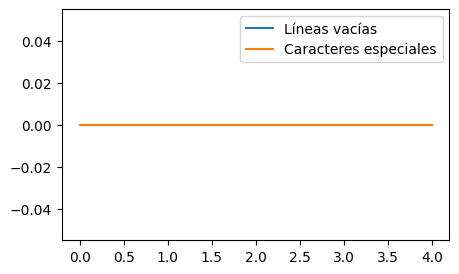

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.plot(df['problems_lineas_vacias'], label='Líneas vacías')
plt.plot(df['problems_caracteres_especiales'], label='Caracteres especiales')
plt.legend()
plt.show()